In [169]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, scanpy as sc
from scipy.io import mmread
from ripser import ripser, Rips,lower_star_img
import persim
from persim import plot_diagrams
import sklearn
from sklearn import datasets
import kmapper as km
from kmapper import jupyter

In [2]:
#Was trying this on a particular data set
fibroblast=sc.read('data_set.h5ad')
color = fibroblast.obs.index
data = pd.DataFrame(fibroblast.X)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [61]:
mapper = km.KeplerMapper(verbose=0)
#One of the important hyperparameter here is the projection. 
#This can not be generalized since it highly depends on which dataset we are looking at and what do we want from it.
projected_data = mapper.fit_transform(data, projection = sklearn.manifold.TSNE(metric= 'correlation',n_jobs=-1))

In [165]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):    
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#Find the cluster number using traditional clustering algorithms.
#NOTE: This can be modified if you want to use some other clustering algorithm
def clust_number(projected_data):
    print('The optimal cluster numbers')
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    #I used both Kmeans and silhoutte_score to get the cluster number.
    #I will choose the smaller cluster number for the graph
    #and the larger cluster number for the coloring.
    wcss = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        cluster_labels = kmeans.fit_predict(projected_data)
        wcss.append(kmeans.inertia_)
    s_score=0
    for i in range(2,15):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        cluster_labels = kmeans.fit_predict(projected_data)
        if silhouette_score(projected_data, cluster_labels)>s_score:
            s_score=silhouette_score(projected_data, cluster_labels)
            index=i
    n_clust=1
    temp = angle_between([-1,wcss[0]- wcss[1]],[1,wcss[2]- wcss[1]])
    for i in range(2,len(wcss)):        
        if (angle_between([-1,wcss[i-2]- wcss[i-1]],[1,wcss[i]- wcss[i-1]])<3*np.pi/4):
            if angle_between([-1,wcss[i-2]- wcss[i-1]],[1,wcss[i]- wcss[i-1]])< temp:
                n_clust=i-1
    print(n_clust,index)
    return [n_clust,index]

#Get parameters for colors
def parameter_color(projected_data):
    arr1 = [i/100 for i in range(1,151,2)]
    arr2 = [i for i in range(2,16,2)]
    b=max(clust_number(projected_data))-1
    for n_min_samples in arr2:
        for n_eps in arr1:
            if b == max(sklearn.cluster.DBSCAN(eps=n_eps,min_samples=n_min_samples,n_jobs=-1).fit(projected_data).labels_):                    
                    return n_eps,n_min_samples    
    return parameter_clust(projected_data)

#Get parameters for clustering the graph
def parameter_clust(projected_data):
    print('getting DBSCAN parameters')
    arr1 = [i/100 for i in range(1,151,2)]
    arr2 = [i for i in range(2,21)]
    b=min(clust_number(projected_data))-1
    for n_min_samples in arr2:
        for n_eps in arr1:
            if b == max(sklearn.cluster.DBSCAN(eps=n_eps,min_samples=n_min_samples,n_jobs=-1).fit(projected_data).labels_):
                print(n_eps,n_min_samples)
                return n_eps,n_min_samples
    return 0.05,3

In [67]:
#DEFINE CLUSTER CUBES:
#Gives a coloring to all the cubes based on connectivity and returns a dictionary
#All the connected cubes and the number of clusters is returned.
def cluster_cubes(graph):
    #print('The Cluster Cubes')
    link_keys=graph['links'].keys()
    node_flag={}
    i=0
    #iterate over link_keys
    for x in link_keys:
        temp=graph['links'][x]
        if x in node_flag.keys():            
            j = node_flag[x]
            for ele in temp:
                if ele in node_flag.keys():
                    j = min(node_flag[ele],j)
            for ele in temp:
                node_flag.update({ele:j})
        else:
            j=50
            for ele in temp:
                if ele in node_flag.keys():
                    j = min(node_flag[ele],j)
            if j==50:                
                node_flag.update({x:i})
                for ele in temp:                
                    node_flag.update({ele:i})
                i+=1
            else:
                node_flag.update({x:j})
                for ele in temp:                
                    node_flag.update({ele:j})
              
    #temporary solution to the ambiguous step  
    #a reverse loop to ensure that all the connected components are actually colored the same
    l = len(list(link_keys))-1
    flag=0
    for num in range(l):
        x=list(link_keys)[l-num]
        temp = graph['links'][x]
        intersection=[k for k in temp if k in node_flag.keys()]
        if len(intersection)==0:
            flag+=1
        else:
            j = node_flag[intersection[0]]
            node_flag.update({x:j})
            for ele in temp:
                node_flag.update({ele:j})
    
    sorted_node_flag = sorted(node_flag.items(), key=lambda item:item[1])
    number_of_clusters = len(list(set(list(node_flag.values()))))-flag
    return dict(sorted_node_flag),number_of_clusters

#Function to see output at different resolutions
#This is an important function. 
#We can also use it directly instead of going through all the resolutions in a particular range
def network(resolution,data,n_eps,n_min_samples):
    print('The network structure')
    i= 15
    j= 0.3
    flag=0
    while(i<=50 and j>=0.1):
        if abs(1.5*i/j - resolution)<10:            
            graph = mapper.map(data,clusterer=sklearn.cluster.DBSCAN(eps=n_eps,
                                                                     min_samples=n_min_samples,n_jobs=-1),
                               cover=km.Cover(i, j))
            if len(graph['nodes'])==0:
                continue
            else:
                return graph
        elif (1.5*i/j - resolution)<0:
            if flag==0:
                i+=2
                flag=1
            else:
                j-=0.02
                flag=0
        else:
            if flag==0:
                i-=2
                flag=1
            else:
                j+=0.02
                flag=0

#Returns the largest node cluster
def largest(graph):
    print('The largest cluster')
    clust_labels = list(cluster_cubes(graph)[0].values())
    len_cluster={}
    j=0
    if len(clust_labels)==0:
        return []
    if len(clust_labels)==1:
        return clust_labels
    for i in range(1,len(clust_labels)):
        if clust_labels[i-1]!=clust_labels[i]:
            len_cluster.update({clust_labels[i-1]:i-j})
            j=i
    len_cluster.update({clust_labels[i-1]:len(clust_labels)-j})
    freq_color = sorted(len_cluster.items(), key = lambda x:x[1], reverse = True)[0][0]
    largest_graph =[]
    for cube,color in cluster_cubes(graph)[0].items():
        if color == freq_color:
            largest_graph.append(cube)
    return largest_graph

#Returns the variance in the valency of the largest cluster/graph
def graph_valency(graph):    
    val_dict={}
    for nodes in largest(graph):
        if nodes in val_dict.keys():
            val_dict.update({nodes:val_dict[items]+len(graph['links'][nodes])})
        else:
            val_dict.update({nodes:len(graph['links'][nodes])})
        for items in graph['links'][nodes]:
            if items in val_dict.keys():
                val_dict.update({items:val_dict[items]+1})
            else:
                val_dict.update({items:1})
    val_array=[]
    for values in val_dict.items():
        val_array.append(values[1])
    print('variance and mean of graph',np.var(val_array), np.mean(val_array))
    return np.var(val_array),np.mean(val_array)

Instead of using the variance and mean just on the largest graph, we can also include the average variance as a parameter.
Average mean is not required, since it can vary a lot in different connected components.

In [ ]:
#Final graph with two hyper_parameter
def final_graph(projected_data,var,mean):
    n_eps = parameter_clust(projected_data)[0]
    n_min_samples = parameter_clust(projected_data)[1]
    #We run the function network with different resolution values and check the variance and the mean in the output graph 
    for i in range(10,205,5):
        print(i)
        vm=graph_valency(network(i,projected_data,n_eps, n_min_samples))
        if var - vm[0]<0.1 and vm[1]-mean<0.1:
            return network(i,projected_data,n_eps,n_min_samples)

getting DBSCAN parameters
The optimal cluster numbers
1 3
0.17 2
getting DBSCAN parameters
The optimal cluster numbers
1 3
0.17 2
10
The network structure
The largest cluster
variance and mean of graph 1.5047258979206048 4.130434782608695
15
The network structure
The largest cluster
variance and mean of graph 1.5047258979206048 4.130434782608695
20
The network structure
The largest cluster
variance and mean of graph 0.9155555555555552 4.466666666666667
25
The network structure
The largest cluster
variance and mean of graph 0.9155555555555552 4.466666666666667
30
The network structure
The largest cluster
variance and mean of graph 1.2623039480800433 4.395348837209302
35
The network structure
The largest cluster
variance and mean of graph 1.2623039480800433 4.395348837209302
40
The network structure
The largest cluster
variance and mean of graph 1.1843644198214833 4.385964912280702
45
The network structure
The largest cluster
variance and mean of graph 1.3856571252693137 4.35087719298245

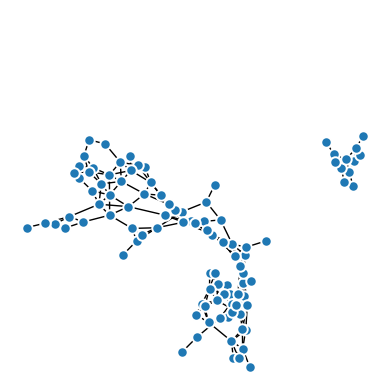

In [125]:
#Drawing the graph 
graph = final_graph(projected_data,2,4)
km.draw_matplotlib(graph)
plt.show()

In [126]:
#Display the html file/graph using mapper
mapper.visualize(graph,path_html='fibr.html',custom_tooltips= np.array(color),
                color_function=sklearn.cluster.DBSCAN(eps=parameter_color(projected_data)[0], min_samples=parameter_color(projected_data)[1],n_jobs=-1).fit(projected_data).labels_)
jupyter.display('fibr.html')

The optimal cluster numbers
1 3
The optimal cluster numbers
1 3


/usr/local/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


One can also check the graph using the funtion network with any particular resolution.
This can sometimes be a good approach to certain problems if there are multiple components or if the background of the data set is not known.

getting DBSCAN parameters
The optimal cluster numbers
1 3
0.17 2
getting DBSCAN parameters
The optimal cluster numbers
1 3
0.17 2
The network structure


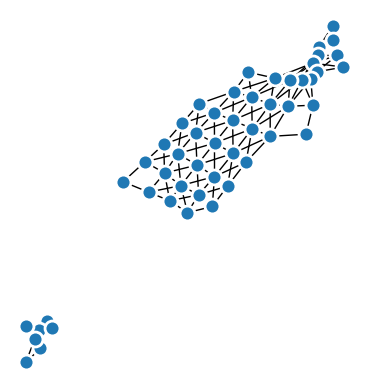

In [129]:
n_eps = parameter_clust(projected_data)[0]
n_min_samples = parameter_clust(projected_data)[1]
km.draw_matplotlib(network(35,projected_data,n_eps, n_min_samples))
plt.show()

Now we will try to find out the path between any two nodes in the given graph.


This I believe can be very important to give the information, not only about the nodes in the same clusters but also about the shortest path from one node point to another. 
It can be used in multiple scenarios which may use time series data.

In [116]:
#DEFINE FUNCTION THAT RETURNS CLUSTERS
def clusters(graph):
    node_info = graph['nodes'].keys()
    data_point_flags={}
    cluster = [[] for i in range(cluster_cubes(graph)[1])]
    for x in node_info:
        node = graph['nodes'][x]
        if x in cluster_cubes(graph)[0].keys():
            node_color = cluster_cubes(graph)[0][x]
            for point in node:
                data_point_flags.update({point:node_color})
    temp = sorted(data_point_flags.items(), key=lambda item:item[1])
    cluster[0].append(temp[0][0])
    j=0
    for i in range(1,len(temp)):
        if temp[i][1]!=temp[i-1][1]:
            cluster[j+1].append(temp[i][0])
            j+=1
        else:
            cluster[j].append(temp[i][0])
    return cluster

def cube_cluster(graph,a,b):
    cube_a=''
    cube_b=''
    for cubes in graph['nodes'].keys():
        for items in graph['nodes'][cubes]:
            if items == a:
                cube_a = cubes
            if items == b:
                cube_b = cubes
            if len(cube_a)>0 and len(cube_b)>0:
                break
    return cube_a,cube_b

from collections import defaultdict

class Graph():
    def __init__(self):
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight

#Shortest path algorithm
def dijsktra(graph, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return []
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return path

def graph_construct(graph):
    g = Graph()
    edges=[]
    for nodes in graph['links'].keys():
        for cubes in graph['links'][nodes]:
            edges.append((cubes,nodes,1))
    for edge in edges:
        g.add_edge(*edge)
    return g

def print_path(graph,cell_1,cell_2):
    path = dijsktra(graph_construct(graph),cube_cluster(graph,cell_1, cell_2)[0],cube_cluster(graph,cell_1, cell_2)[1])
    dist = len(path)
    if dist==0:
        return 'Route not possible'
    if dist>2:
        for i in range(1,dist-1):
            print (sorted(list(color[graph['nodes'][path[i]]])))
    else:
        print('they are connected')

In [130]:
print_path(graph,4,218)

['M1_C04', 'M2_H05', 'M3_A05', 'M3_A09', 'M3_F03']
['M1_A05', 'M1_A10', 'M1_B02', 'M1_H05', 'M3_A09', 'M3_B10']
['M1_A10', 'M1_D03', 'M1_H05', 'M2_E02', 'M2_E03', 'M3_E08']
['M2_A08', 'M2_C09', 'M2_D07', 'M2_E11', 'M2_H09', 'M3_D11', 'M3_E04', 'M3_E08', 'M3_H04']
['M2_C06', 'M2_D07', 'M2_G04', 'M2_H02', 'M3_A04', 'M3_C10', 'M3_D02', 'M3_E05', 'M3_E11']
['M2_D05', 'M2_D11', 'M2_H02', 'M2_H06', 'M3_D02', 'M3_D10', 'M3_E05', 'M3_E11', 'M3_H03']


An example to show how mapper works for a small 2-dimensional image.
A picture of hand with a very simple and fast function shows us that there are five different clusters in the picture, depicting the five fingers.

In [ ]:
import PIL
from scipy import ndimage
hand_original = plt.imread("hand.jpg")
hand_grey = np.asarray(PIL.Image.fromarray(hand_original).convert('L'))
smoothed = ndimage.uniform_filter(hand_grey.astype(np.float64), size=5)
projected_hand = mapper.fit_transform(smoothed)
graph2 = final_graph(projected_hand,0.5,4)
km.draw_matplotlib(graph2)
plt.show()

In [160]:
mapper.visualize(graph2,path_html='hand.html')
jupyter.display('hand.html')

/usr/local/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
